In [322]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve



conn = create_engine('postgresql://ubuntu@52.53.236.232:5432/collegesc')

%matplotlib inline

## Helper functions and other definitions

In [323]:
def query_data_def(conn, var_name):
    """
    var_name: name of column to query
    returns query from datadefinitions table showing definition of data
    """
    query = "SELECT * FROM datadefinitions WHERE developername='"+var_name+"';"
    return conn.execute(query).fetchall()

## Start with school table

In [324]:
school_all = """SELECT * FROM school;"""

In [325]:
school_df = pd.read_sql_query(school_all, conn)

In [326]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 43 columns):
index                                   7703 non-null int64
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
accreditor                              6805 non-null object
alias                                   2178 non-null object
branches                                7703 non-null int64
carnegie_basic                          7282 non-null float64
carnegie_size_setting                   7282 non-null float64
carnegie_undergrad                      7282 non-null float64
city                                    7703 non-null object
degree_urbanization                     0 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
degrees_awarded.predominant_recoded     0 

In [327]:
school_df.under_investigation.value_counts()

0    7467
1     236
Name: under_investigation, dtype: int64

### Remove uninteresting columns or columns with explicit or encoded nulls

In [328]:
school_columns = list(school_df.columns.values)

In [329]:
school_columns.remove('index')
school_columns.remove('alias')
school_columns.remove('degree_urbanization')
school_columns.remove('degrees_awarded.predominant_recoded')
school_columns.remove('faculty_salary')
school_columns.remove('ft_faculty_rate')
school_columns.remove('price_calculator_url')
school_columns.remove('url')
school_columns.remove('zip')
school_columns.remove('carnegie_basic')
school_columns.remove('carnegie_size_setting')
school_columns.remove('carnegie_undergrad')
school_columns.remove('online_only')
school_columns.remove('accreditor')
school_columns.remove('under_investigation')

## Select only interesting features and add/recode features

In [331]:
operating_query = 'SELECT \n school."' + '",school."'.join(school_columns) + '",repayment."3_yr_default_rate"'
operating_query += ', aid."federal_loan_rate", aid."pell_grant_rate"'
operating_query += """                       
                    FROM 
                        school
                    JOIN repayment ON school.id=repayment.id
                    JOIN aid ON school.id=aid.id;"""

In [332]:
school_df = pd.read_sql_query(operating_query, conn)

In [333]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 31 columns):
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
branches                                7703 non-null int64
city                                    7703 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
institutional_characteristics.level     7703 non-null int64
instructional_expenditure_per_fte       7270 non-null float64
locale                                  7282 non-null float64
main_campus                             7703 non-null int64
men_only                                7282 non-null float64
minority_serving.aanipi                 7282 non-null float64
minority_serving.annh                   7282 non-null float64
minority_serving.hispanic             

### Recode locale to 4 values instead of 12

In [334]:
locale_recode = school_df.locale.astype(str).values

In [335]:
locale_recode = [int(x[0]) if x[0] in ['1','2','3'] else 0 for x in locale_recode]

In [336]:
school_df['locale_recode'] = locale_recode

In [337]:
school_df['locale_recode'].value_counts()

1    3509
2    2291
0     986
3     917
Name: locale_recode, dtype: int64

### Recode religion to religious and non-religious

In [338]:
religion_recode = (np.nan_to_num(school_df.religious_affiliation.values) > 0).astype(int)

In [339]:
np.unique(religion_recode)

array([0, 1])

In [340]:
school_df['religion_recode'] = religion_recode

In [341]:
school_df.religion_recode.value_counts()

0    6793
1     910
Name: religion_recode, dtype: int64

### Check other variables

In [90]:
for column in school_df.columns:
    print(column+" value counts")
    print(school_df[column].value_counts())

id value counts
217086      1
216667      1
177588      1
449977      1
179645      1
236993      1
476610      1
107974      1
171465      1
150987      1
130509      1
169424      1
155089      1
156417      1
226772      1
452054      1
191959      1
161244      1
213491      1
480736      1
175591      1
417257      1
181738      1
194028      1
409069      1
372329      1
431600      1
230898      1
152336      1
478643      1
           ..
23368407    1
197285      1
449214      1
187046      1
189097      1
203438      1
418481      1
190044      1
139393      1
201399      1
261773      1
467641      1
457402      1
461500      1
459453      1
476902      1
127699      1
230852      1
213215      1
209603      1
182980      1
16947910    1
447175      1
174792      1
205513      1
228042      1
406219      1
16947918    1
234191      1
149505      1
Name: id, Length: 7703, dtype: int64
location.lat value counts
0.000000     421
40.760050      2
38.655362      2
32.955170      2

### Recode gender-specific schools

In [342]:
school_df['gender_specific'] = np.nan_to_num((school_df.men_only + school_df.women_only).values)

In [343]:
school_df.gender_specific.value_counts()

0.0    7598
1.0     105
Name: gender_specific, dtype: int64

### Recode minority-serving schools

In [344]:
minority_specific = np.nan_to_num((school_df['minority_serving.aanipi'] +\
                        school_df['minority_serving.annh'] +\
                        school_df['minority_serving.hispanic'] +\
                        school_df['minority_serving.historically_black'] +\
                        school_df['minority_serving.nant'] +\
                        school_df['minority_serving.predominantly_black'] +\
                        school_df['minority_serving.tribal']).values)

In [345]:
minority_specific = (minority_specific > 0).astype(int)

In [346]:
school_df['minority_specific'] = minority_specific

### Recode for-profit vs. non-profit (private or public) for initial classification

In [347]:
school_df['for_profit'] = (school_df.ownership == 3).astype(int)

In [348]:
school_df.for_profit.value_counts()

0    4000
1    3703
Name: for_profit, dtype: int64

In [349]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 36 columns):
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
branches                                7703 non-null int64
city                                    7703 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
institutional_characteristics.level     7703 non-null int64
instructional_expenditure_per_fte       7270 non-null float64
locale                                  7282 non-null float64
main_campus                             7703 non-null int64
men_only                                7282 non-null float64
minority_serving.aanipi                 7282 non-null float64
minority_serving.annh                   7282 non-null float64
minority_serving.hispanic             

### Pare down to relevant columns and remove nulls

In [350]:
cleaned_school_df = school_df.drop(['locale', 'men_only',
                                    'minority_serving.aanipi', 'minority_serving.annh',
                                    'minority_serving.hispanic', 'minority_serving.historically_black',
                                    'minority_serving.nant', 'minority_serving.predominantly_black',
                                    'minority_serving.tribal', 'religious_affiliation', 'state', 
                                    'state_fips','women_only'], axis = 1)

In [351]:
cleaned_school_df = cleaned_school_df.loc[cleaned_school_df.tuition_revenue_per_fte.notnull()]

In [352]:
cleaned_school_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7270 entries, 0 to 7702
Data columns (total 23 columns):
id                                     7270 non-null int64
location.lat                           7270 non-null float64
location.lon                           7270 non-null float64
branches                               7270 non-null int64
city                                   7270 non-null object
degrees_awarded.highest                7270 non-null int64
degrees_awarded.predominant            7270 non-null int64
institutional_characteristics.level    7270 non-null int64
instructional_expenditure_per_fte      7270 non-null float64
main_campus                            7270 non-null int64
name                                   7270 non-null object
operating                              7270 non-null int64
ownership                              7270 non-null int64
region_id                              7270 non-null int64
tuition_revenue_per_fte                7270 non-null float6

In [353]:
main_campus_df = cleaned_school_df.loc[(cleaned_school_df.branches>1) & (cleaned_school_df.main_campus == 1) | (cleaned_school_df.branches == 1)]

In [354]:
main_campus_df['not_operating'] =  1 - main_campus_df.operating

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [355]:
main_campus_df.not_operating.value_counts()

0    5377
1     299
Name: not_operating, dtype: int64

In [319]:
main_campus_df['federal_loan_rate'].describe()

count    5310.000000
mean        0.486539
std         0.288095
min         0.000000
25%         0.254625
50%         0.540950
75%         0.713500
max         1.000000
Name: federal_loan_rate, dtype: float64

In [358]:
main_campus_df = main_campus_df.fillna(main_campus_df.mean())

## Select columns for classification


In [364]:
X = main_campus_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = main_campus_df.not_operating

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [366]:
log_model = LogisticRegression(penalty='l1')

In [367]:
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [368]:
prob_operating = log_model.predict_proba(X_test)

In [369]:
log_loss(y_test, prob_operating[:, 1])

0.17727352515004691

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


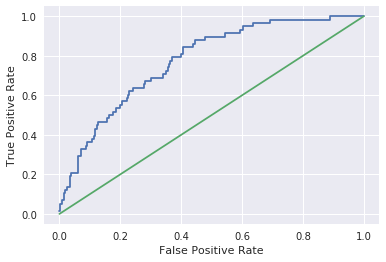

In [370]:
fpr, tpr, thresholds = roc_curve(y_test,prob_operating[:, 1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [371]:
roc_auc_score(y_test, prob_operating[:, 1])

0.7743106647047534

In [372]:
log_model.classes_

array([0, 1])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


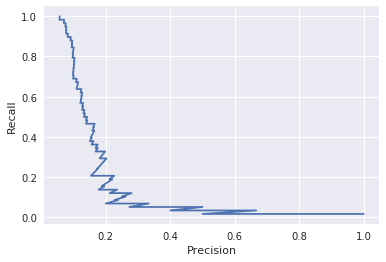

In [373]:
prec, recall, thresholds = precision_recall_curve(y_test,prob_operating[:, 1])
plt.plot(prec[0:-1], recall[0:-1])
plt.xlabel("Precision")
plt.ylabel("Recall")

In [374]:
list(zip(X.columns, log_model.coef_[0]))

[('location.lat', 0.013716737745502755),
 ('location.lon', -0.00089163423623568312),
 ('branches', 0.030881499904495929),
 ('degrees_awarded.highest', -0.56773335369832278),
 ('degrees_awarded.predominant', -0.33024370153205612),
 ('institutional_characteristics.level', -0.62103638229366931),
 ('instructional_expenditure_per_fte', 1.1928034226145749e-06),
 ('main_campus', -1.3019063163982882),
 ('tuition_revenue_per_fte', 1.3313988070332986e-05),
 ('3_yr_default_rate', 1.8597042254547582),
 ('federal_loan_rate', -0.46911457213439572),
 ('pell_grant_rate', 2.0021165471270921),
 ('locale_recode', -0.071868380371765114),
 ('religion_recode', 0.21493858878736957),
 ('gender_specific', -0.35419149384791027),
 ('minority_specific', -0.89713548649660269),
 ('for_profit', 1.1002437647520971)]

In [191]:
y_test.sum()/len(y_test)

0.04841549295774648

In [192]:
y_train.sum()/len(y_train)

0.053744493392070485